In [1]:
import pandas
import os

def symbol_to_path(symbol, base_dir="data"):
    """Return CSV path for file"""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates):
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    joined_frame = pandas.DataFrame(index=dates)
    for symbol in symbols:
        symbol_frame = pandas.read_csv(symbol_to_path(symbol),
                                index_col="Date",
                                parse_dates=True,
                                usecols=["Date", "Adj Close"]                 
                               )
        joined_frame = joined_frame.join(symbol_frame, how="inner").rename(columns={'Adj Close': symbol})
    return joined_frame

dates = pandas.date_range("2019-04-01", "2020-04-01")
symbols = ["GOOG", "IBM", "GLD"]

data_frame = get_data(symbols, dates)
data_frame

,SPY,GOOG,IBM,GLD
2019-04-01,280.106659,1194.430054,136.905136,121.529999
2019-04-02,280.243835,1200.489990,136.618515,121.980003
2019-04-03,280.684845,1205.920044,137.220383,121.800003
2019-04-04,281.429596,1215.000000,136.408325,122.110001
2019-04-05,282.791809,1207.150024,136.886017,121.980003
...,...,...,...,...
2020-03-19,239.103989,1115.290039,100.339996,138.039993
2020-03-20,228.800003,1072.319946,95.389999,140.110001
2020-03-23,222.949997,1056.619995,94.769997,146.300003
2020-03-24,243.149994,1134.459961,105.480003,153.399994


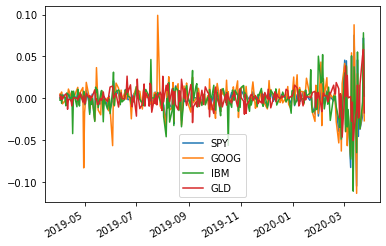

In [2]:
scaled_frame = data_frame / data_frame.values[0]
daily_returns = scaled_frame[1:] - scaled_frame.values[0:-1]
daily_returns.plot()

Max 1226696.35738598
Min 861832.7311391518


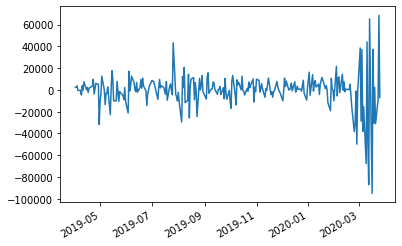

In [3]:
initial_value = 1000000
allocation = [0.4, 0.4, 0.1, 0.1]

position_values = (scaled_frame * allocation) * initial_value
portfolio_value = position_values.sum(axis=1)
print("Max", portfolio_value.max())
print("Min", portfolio_value.min())
daily_returns = position_values[1:] - position_values.values[0:-1]
portfolio_returns = daily_returns.sum(axis=1)
portfolio_returns.plot()


In [4]:
cummulative_return = portfolio_value[-1] - portfolio_value[0] - 1
average_daily_return = portfolio_returns.mean()
std_daily_return = portfolio_returns.std()
cummulative_return, average_daily_return, std_daily_return

(-76555.39379451843, -308.6870717520905, 16330.986589722268)

In [5]:
# returns the negative sharpe ratio (without risk-free return)
def negative_sharpe(allocations):
    portfolio_returns = (scaled_frame * allocations).sum(axis=1)
    average_daily_return = portfolio_returns.mean()
    std_daily_return = portfolio_returns.std()
    return - average_daily_return / std_daily_return
    

import scipy.optimize as spo
import numpy as np

init_guess = np.array([0.20, 0.20, 0.30, 0.30])
min_result = spo.minimize(
    negative_sharpe,
    init_guess,
    method='SLSQP',
    tol=1e-20,
    bounds=np.array([[0.0, 1.0]] * 4),
    options={
        "disp": True        
    })
print("Minima Found:")
print("X = {}, Y = {}", min_result.x, min_result.fun)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -19.7798536488714
            Iterations: 13
            Function evaluations: 88
            Gradient evaluations: 11
Minima Found:
X = {}, Y = {} [1.16794374e-15 2.75150626e-15 9.96529299e-01 7.71758515e-01] -19.7798536488714


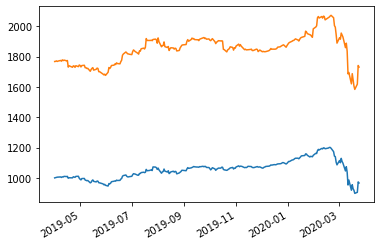

In [10]:
portfolio_guess = (scaled_frame * init_guess).sum(axis=1) * 1000
portfolio_optimized = (scaled_frame * min_result.x).sum(axis=1) * 1000

portfolio_guess.plot(label="guess")
portfolio_optimized.plot(label="opt")